In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

In [2]:
df = pd.read_csv("data library/Soja_v1.csv", sep=";")
df = df.sort_values(by="Data")
df = df.reset_index(drop=True)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [3]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [5]:
clima = pd.read_csv("data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [6]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['Estadual'].shift(1)
df.head()

,Data,Cultivo,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457,175.4,24.9,NaN
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985,175.4,24.5,45.3777
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419,23.0,21.7,45.9456
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148,18.8,22.1,44.8723
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777,38.0,22.2,38.5913


In [ ]:
df_omc = pd.read_csv("data library/indice_omc.csv", sep=',')
df_omc = df_omc[:-3]
df_omc.rename(columns={"Index":"OMC"}, inplace=True)
df_1 = df.merge(df_omc, how="right")
df = df_1.copy()

EDA

In [21]:
df.describe()

,Estadual,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,OMC
count,225.000000,225.000000,225.0,225.000000,225.000000,225.000000,225.000000,225.000000,218.000000,222.000000,225.000000,225.000000
mean,70.659080,74.536126,0.0,34580.975499,34452.415693,26556.886533,43864.268093,3.191376,95.757798,24.618018,70.209837,6.453333
std,42.456387,42.976103,0.0,43112.118014,42987.928566,40618.538598,43835.296714,1.347770,108.385018,1.166594,42.427245,17.572523
min,17.383800,22.010400,0.0,1.005100,1.000120,1.003120,1.000880,1.563938,0.000000,21.400000,17.383800,-36.000000
25%,38.951200,42.294000,0.0,1.257000,1.248380,1.218630,1.287630,2.028079,12.050000,24.000000,38.949600,-7.000000
50%,57.575800,61.951200,0.0,1.479500,1.487130,1.459880,54050.000000,3.061715,42.600000,24.400000,57.439100,6.000000
75%,77.657800,79.527800,0.0,87825.000000,87612.000000,73200.000000,89112.000000,4.149464,141.400000,25.400000,76.914000,19.000000
max,179.294900,191.998900,0.0,99975.000000,99675.000000,99988.000000,99563.000000,5.651391,492.200000,27.800000,179.294900,53.000000


In [22]:
df[["Estadual", "País", "Último", "Abertura", "Máxima", "Mínima", "USD", "Precipitacao", "Temperatura", "lag_Estadual", "OMC"]].corr()

,Estadual,País,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,OMC
Estadual,1.000000,0.996574,-0.320295,-0.323825,-0.262264,-0.371127,0.897946,-0.213528,0.284066,0.992811,-0.004650
País,0.996574,1.000000,-0.319870,-0.325246,-0.261646,-0.377534,0.897081,-0.192143,0.268511,0.993325,0.014967
Último,-0.320295,-0.319870,1.000000,0.762143,0.776900,0.746950,-0.027190,0.018071,-0.013955,-0.319614,-0.257730
Abertura,-0.323825,-0.325246,0.762143,1.000000,0.773528,0.752487,-0.029323,-0.007702,0.044852,-0.331738,-0.280165
Máxima,-0.262264,-0.261646,0.776900,0.773528,1.000000,0.569845,0.026243,0.089778,0.030736,-0.264068,-0.209005
Mínima,-0.371127,-0.377534,0.746950,0.752487,0.569845,1.000000,-0.084826,-0.036616,-0.046268,-0.373453,-0.374178
USD,0.897946,0.897081,-0.027190,-0.029323,0.026243,-0.084826,1.000000,-0.147115,0.323848,0.892292,-0.174005
Precipitacao,-0.213528,-0.192143,0.018071,-0.007702,0.089778,-0.036616,-0.147115,1.000000,0.017772,-0.187082,0.092395
Temperatura,0.284066,0.268511,-0.013955,0.044852,0.030736,-0.046268,0.323848,0.017772,1.000000,0.276404,-0.064277
lag_Estadual,0.992811,0.993325,-0.319614,-0.331738,-0.264068,-0.373453,0.892292,-0.187082,0.276404,1.000000,0.013593


Text(0.5, 1.0, 'Correlation Heatmap')

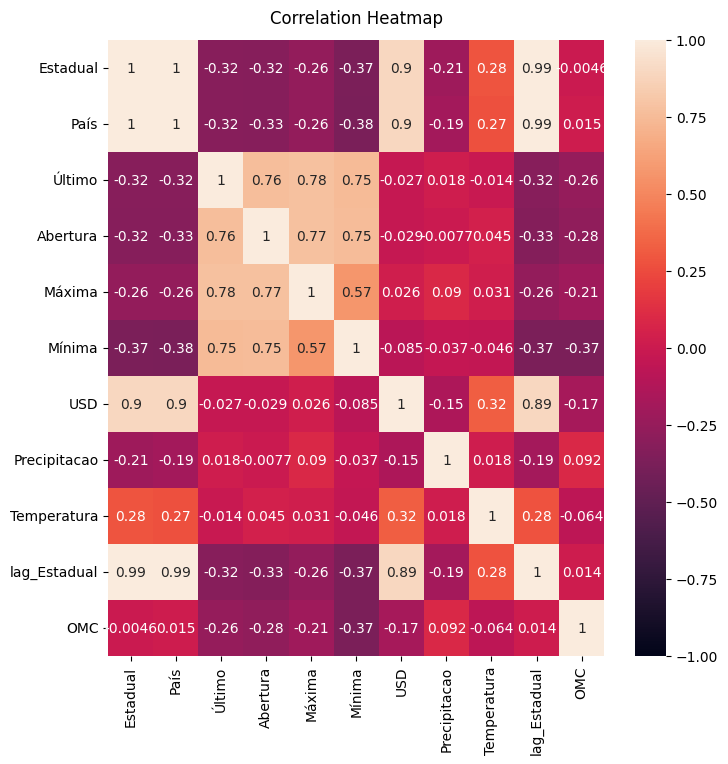

In [23]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df[["Estadual", "País", "Último", "Abertura", "Máxima", "Mínima", "USD", "Precipitacao", "Temperatura", "lag_Estadual","OMC"]].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

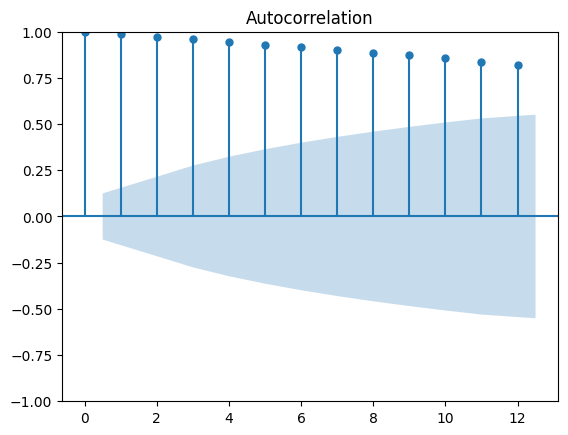

<Figure size 3000x1000 with 0 Axes>

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Estadual, lags=12)
plt.figure(figsize=(30,10))
plt.show()

In [19]:
train_size = 0.8
test_size = 0.2

train_start = df.Data[0]
train_end = df.Data[int(len(df)*0.8)]

test_start = df.Data[int(len(df)*0.8)]
test_end = df.Data[len(df)-1]

print(train_start)
print(train_end)
print(test_start)
print(test_end)


2004-03-01
2020-08-01
2020-08-01
2024-09-01


Linear Regression

In [81]:
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression

In [7]:
df1 = df.copy()

df1['Data'] = pd.to_datetime(df1['Data'])
df1["Time"] = df.index

train_df = df1[:(int(len(df1)*0.8))].copy()
test_df = df1[(int(len(df1)*0.8)+1):].copy()

In [8]:
X = df1.loc[:, ['Time']]  # features
y = df1.loc[:, 'Estadual']  # target

AutoRegressive

In [20]:
df1 = df.copy()

df1['Data'] = pd.to_datetime(df1['Data'])
df1.set_index('Data', inplace = True)
df1.dropna(inplace=True)
df1 = df1.asfreq('ME', method = 'bfill') 
df1 = df1[["Estadual", "País"]]

train_df = df1[:(int(len(df1)*0.8))].copy()
test_df = df1[(int(len(df1)*0.8)):].copy()

display(df1)

,Estadual,País
Data,,
2004-03-31,45.9456,48.7279
2004-04-30,44.8723,47.4930
2004-05-31,38.5913,40.7781
2004-06-30,34.0818,37.5474
2004-07-31,31.8333,34.9411
...,...,...
2024-04-30,114.0022,118.2335
2024-05-31,118.9727,121.3981
2024-06-30,120.0369,121.7345


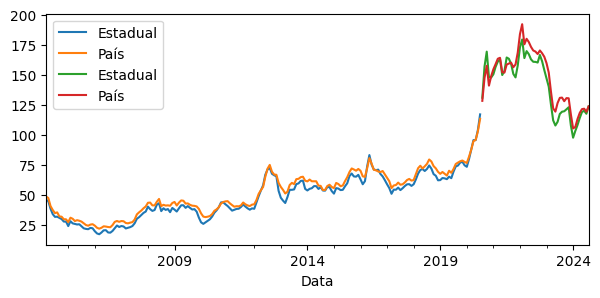

In [21]:
fig, ax = plt.subplots(figsize=(7, 3))
df1.loc[train_start:train_end].plot(ax=ax, label = "Train")
df1.loc[test_start:test_end].plot(ax=ax, label = "Test")
ax.legend()

MAE: 38.19151541194563
RMSE: 46.600970923791756
MAPE: 0.24574027104984927
R-Squared: -3.2280939107410322


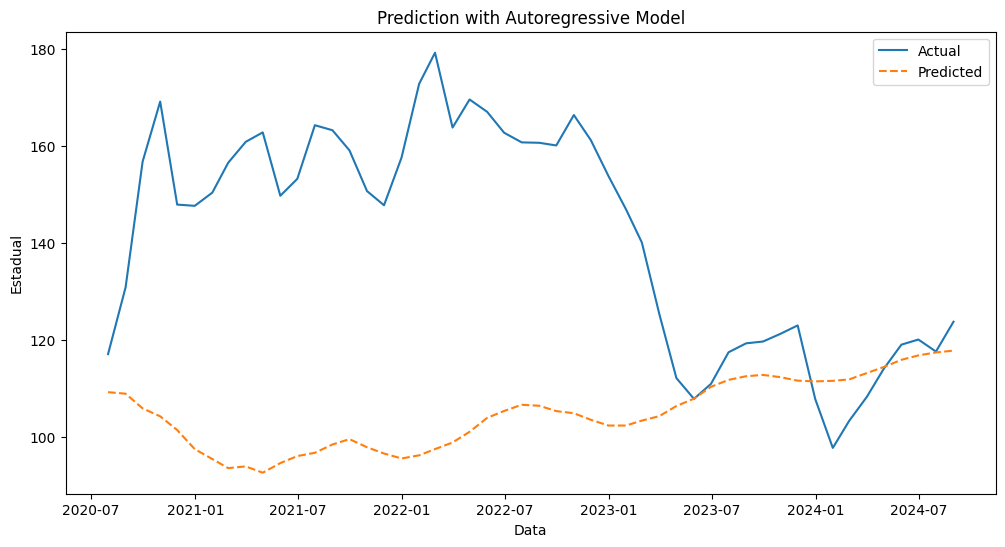

In [24]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score


# split dataset
X = df1[["Estadual"]].values
train = train_df["Estadual"]
test = test_df["Estadual"]
# train autoregression
model = AutoReg(train, lags=29)
model_fit = model.fit()
# print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
# for i in range(len(predictions)):
#     print('predicted=%f, expected=%f' % (predictions[i], test[i]))

test_df["Data"] = test_df.index

print(f"MAE: {mean_absolute_error(test, predictions)}")
print(f"RMSE: {root_mean_squared_error(test, predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(test, predictions)}")
print(f"R-Squared: {r2_score(test, predictions)}")

plt.figure(figsize=(12, 6))
plt.plot(test_df["Data"], test, label='Actual')
plt.plot(test_df["Data"], predictions, label='Predicted', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Estadual')
plt.legend()
plt.title('Prediction with Autoregressive Model')
plt.show()

In [ ]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

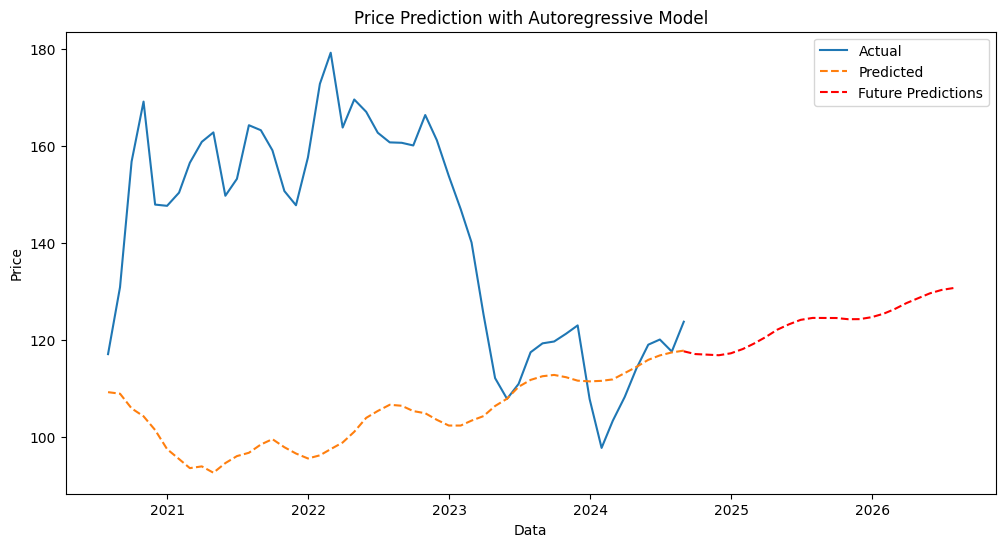

In [10]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps = 24
 
# Extend the predictions into the future for one year
future_indices = range(len(test_df), len(test_df) + forecast_steps)
future_predictions = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) + forecast_steps - 1, dynamic=False)

# Create date indices for the future predictions
future_dates = pd.date_range(start=test_df['Data'].iloc[-1], periods=forecast_steps, freq='ME')
 
# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', linestyle='--')
plt.plot(future_dates, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('Data')
plt.ylabel('Price')
plt.legend()
plt.title('Price Prediction with Autoregressive Model')
plt.show()

In [89]:
future_predictions[-forecast_steps:]

2024-08-31    117.748252
2024-09-30    117.598584
2024-10-31    117.031586
2024-11-30    116.912677
2024-12-31    116.791994
2025-01-31    117.191302
2025-02-28    118.075309
2025-03-31    119.161214
2025-04-30    120.534945
2025-05-31    122.058809
2025-06-30    123.192528
2025-07-31    124.103496
2025-08-31    124.501688
2025-09-30    124.490258
2025-10-31    124.481411
2025-11-30    124.235999
2025-12-31    124.251080
2026-01-31    124.656820
2026-02-28    125.373288
2026-03-31    126.307839
2026-04-30    127.558972
2026-05-31    128.562561
2026-06-30    129.584230
2026-07-31    130.280087
Freq: ME, dtype: float64

ARMA & ARIMA

In [3]:
#Import libraries 
import inspect
import time
import warnings
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [4]:
df2 = df.copy()

df2['Data'] = pd.to_datetime(df2['Data'])
#df2.set_index('Data', inplace = True)
#df2.dropna(inplace=True)
#df2 = df2.asfreq('ME', method = 'bfill') 
df2 = df2[["Data","Estadual"]]


df2["Month"] = df2["Data"].dt.month
df2["Quarter"] = df2["Data"].dt.quarter
df2["Year"] = df2["Data"].dt.year

train_df = df2[:(int(len(df2)*0.8))].copy()
test_df = df2[(int(len(df2)*0.8)):].copy()

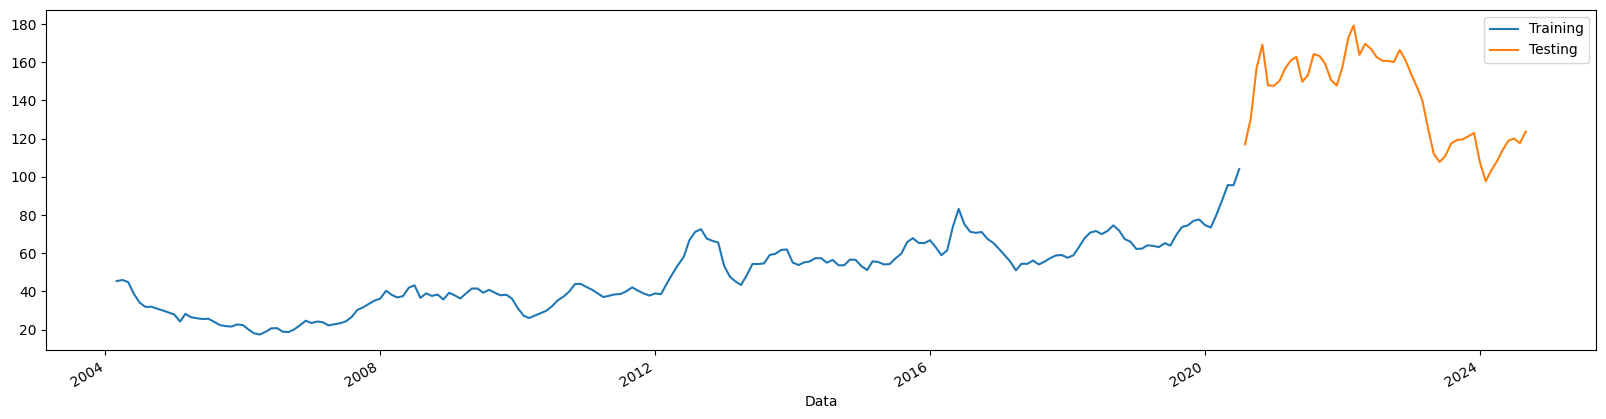

In [5]:
figure, ax = plt.subplots(figsize=(20, 5))
train_df.plot(ax=ax, label="Training", x="Data", y="Estadual")
test_df.plot(ax=ax, label="Testing", x="Data", y="Estadual")
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df2['Estadual'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.131198
p-value: 0.702472


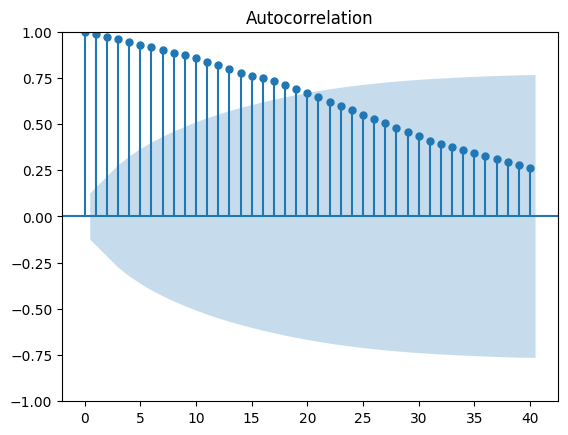

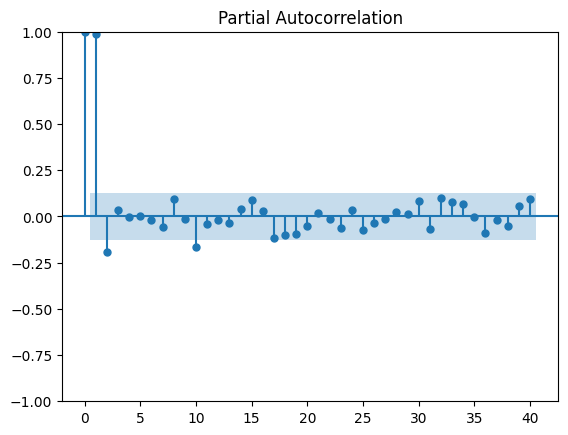

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df2['Estadual'], lags=40)
plot_pacf(df2['Estadual'], lags=40)
plt.show()

In [79]:
training_data = train_df.copy()
testing_data = test_df.copy()

In [80]:
training_data = training_data.drop(columns=["Data"])
testing_dates = testing_data["Data"]
testing_data = testing_data.drop(columns=["Data"])

X_train = training_data[["Month", "Quarter", "Year"]]
y_train = training_data["Estadual"]

X_test = testing_data[["Month", "Quarter", "Year"]]
y_test = testing_data["Estadual"]

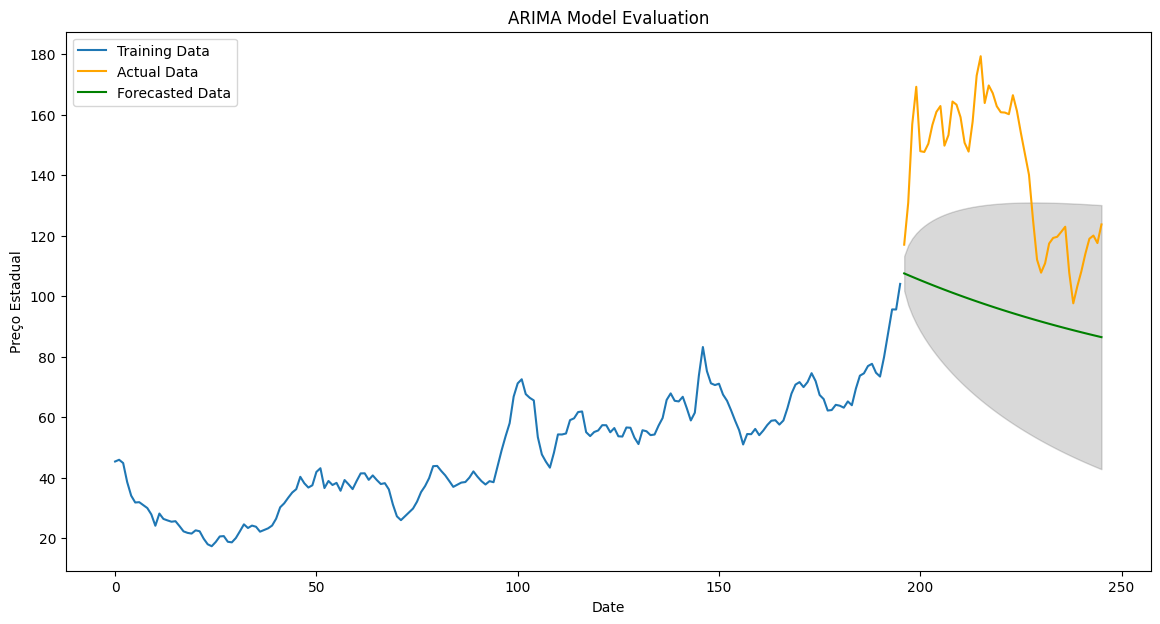

RMSE: 49.576288731220764


In [12]:
from sklearn.metrics import mean_squared_error

# Split the data into train and test
train_size = int(len(df2) * 0.8)
train, test = df2[0:train_size], df2[train_size:len(df2)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['Estadual'], order=(1, 0, 1))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['Estadual'], test_forecast_series)
rmse = mse**0.5

plt.figure(figsize=(14,7))
plt.plot(train['Estadual'], label='Training Data')
plt.plot(test['Estadual'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Preço Estadual')
plt.legend()
plt.show()

print('RMSE:', rmse)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")


In [38]:
evaluate_model(test['Estadual'], test_forecast_series)

MAE: 45.61256841432183
RMSE: 49.576288731220764
MAPE: 0.3080479584430232
R-Squared: -3.7852289266268553


XGBoost

In [81]:
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# XGBoost
cv_split = TimeSeriesSplit(n_splits=2, test_size=len(X_test))
model = XGBRegressor()
parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}


grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=50),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, impor...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]})

In [85]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  _, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

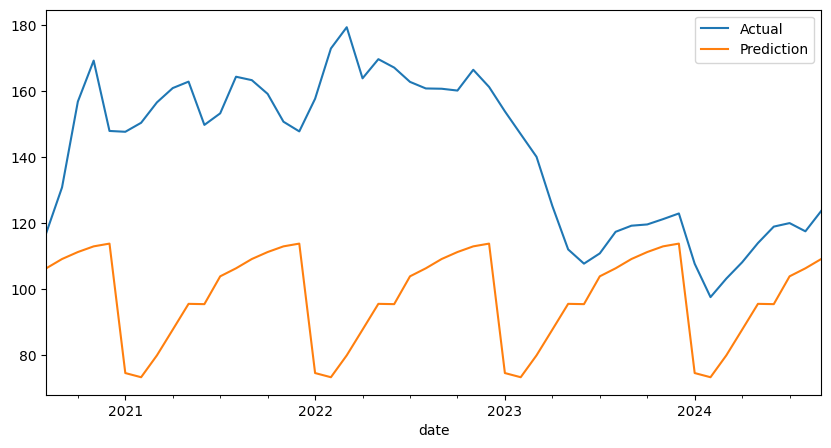

MAE: 44.10129410766601
RMSE: 51.33452317207814
MAPE: 0.2935026994358033


In [86]:

# Evaluating GridSearch results
prediction = grid_search.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)